# Clustering Gijs

In [2]:
import pandas as pd
import numpy as np     
import matplotlib.pyplot as plt
import seaborn as sns

fragmenten_df = pd.read_csv('Data/fragments_data.csv')
birchFragmenten_df = fragmenten_df.copy()
birchFragmenten_df.head()

,fragment,labels,label_numeric
0,05190.100417.watersniproepEempolder_fragment_0...,watersnip,0
1,05190.100417.watersniproepEempolder_fragment_1...,watersnip,0
2,05190.100417.watersniproepEempolder_fragment_2...,watersnip,0
3,05190.100417.watersniproepEempolder_fragment_3...,watersnip,0
4,05190.100417.watersniproepEempolder_fragment_4...,watersnip,0


In [3]:
from sklearn.model_selection import train_test_split
train_data, test_data = train_test_split(birchFragmenten_df, test_size=0.3, random_state=42)
test_data.head()

,fragment,labels,label_numeric
948,XC466471-Redshank (2)_fragment_0.wav,tureluur,1
3036,XC749107-2022-09-14 2020 Oeverlopers_fragment_...,oeverloper,4
1960,XC590410-200918_0480_2257_Watersnip_fragment_1...,watersnip,0
3543,XC834752-01.-1950-2050-watersnip_fragment_5.wav,watersnip,0
1689,"XC561755-Oeverloper, flight call, IGS, 050520,...",oeverloper,4


In [4]:
label_counts = test_data['labels'].value_counts()
print(label_counts)

labels
tureluur                  362
oeverloper                256
witgat                    202
watersnip                 170
zwarte ruiter             149
geelpootruiter             11
grauwe franjepoot          10
steenloper                  7
steltloper                  3
amerikaanse oeverloper      1
Name: count, dtype: int64


In [6]:
import librosa
import matplotlib.pyplot as plt
from IPython.display import Audio
import pandas as pd
from scipy.signal import stft
from scipy.spatial.distance import pdist, squareform
from sklearn.preprocessing import StandardScaler

    


In [7]:
# Initialize the features and filenames lists
features = []
filenames = []

for fragment in test_data['fragment']:
    y, sr = librosa.load("audio_fragments/" + fragment, sr=None)
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
    mfcc_mean = np.mean(mfcc.T, axis=0)

    _, _, Zxx = stft(y, sr, nperseg=1024)
    stft_mean = np.mean(np.abs(Zxx))

    stft_librosa = librosa.stft(y, n_fft=1024, hop_length=512)
    stft_librosa_mean = np.mean(np.abs(stft_librosa))

    feature_vector = np.concatenate([mfcc_mean, [stft_mean], [stft_librosa_mean]])
    features.append(feature_vector)
    filenames.append(fragment)

features = np.array(features)

scaler = StandardScaler()
features = scaler.fit_transform(features)

distance_matrix = squareform(pdist(features, metric='euclidean'))


c:\Users\Gijs Minnen\anaconda3\Lib\site-packages\paramiko\pkey.py:82: CryptographyDeprecationWarning: TripleDES has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.TripleDES and will be removed from this module in 48.0.0.
  "cipher": algorithms.TripleDES,
c:\Users\Gijs Minnen\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.Blowfish and will be removed from this module in 45.0.0.
  "class": algorithms.Blowfish,
c:\Users\Gijs Minnen\anaconda3\Lib\site-packages\paramiko\transport.py:243: CryptographyDeprecationWarning: TripleDES has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.TripleDES and will be removed from this module in 48.0.0.
  "class": algorithms.TripleDES,
c:\Users\Gijs Minnen\anaconda3\Lib\site-packages\librosa\core\spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1083
  warnings.warn(
c:\Users\Gijs Minn

In [8]:
from sklearn.manifold import TSNE

# Ensure features array is valid before applying t-SNE
if np.isnan(features).any() or np.isinf(features).any():
    print("Error: Features array contains NaN or infinite values. Please check your data.")
else:
    tsne = TSNE(n_components=2, random_state=42)
    features_tsne = tsne.fit_transform(features)

c:\Users\Gijs Minnen\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] Het systeem kan het opgegeven bestand niet vinden
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\Gijs Minnen\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "c:\Users\Gijs Minnen\anaconda3\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Gijs Minnen\anaconda3\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "c:\Users\Gijs Minnen\anaconda3\Lib\subprocess.py", line 1538, in _execute_child
  

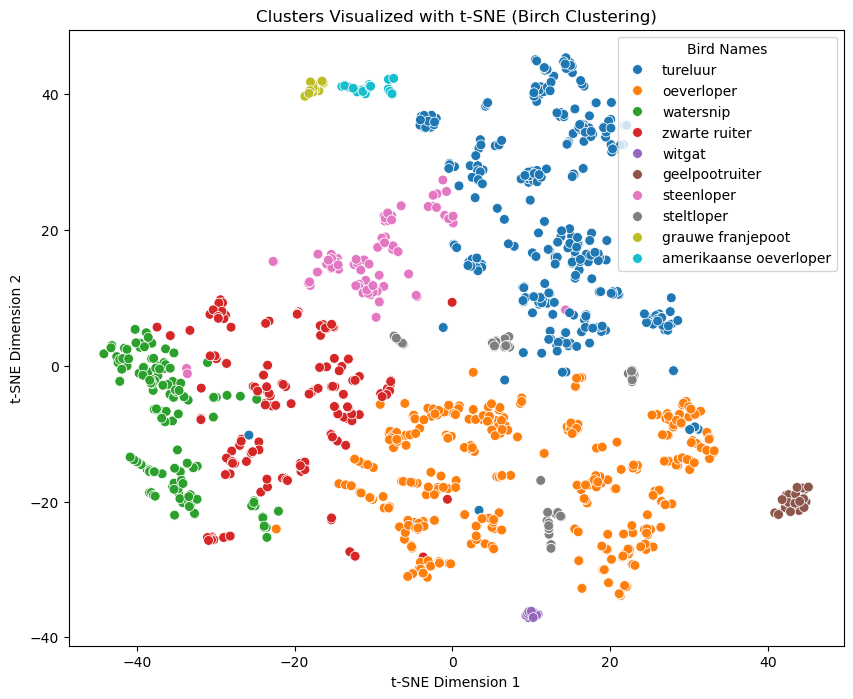

In [15]:
from sklearn.cluster import Birch

# Perform Birch clustering
birch = Birch(n_clusters=10, threshold=0.1)
test_data['cluster'] = birch.fit_predict(features)

# Map cluster numbers to bird names
cluster_to_bird_name = {cluster: bird_name for cluster, bird_name in zip(test_data['cluster'].unique(), test_data['labels'].unique())}

# Replace cluster numbers with bird names
test_data['cluster_name'] = test_data['cluster'].map(cluster_to_bird_name)

# Display the updated test_data
plt.figure(figsize=(10, 8))
sns.scatterplot(x=features_tsne[:, 0], y=features_tsne[:, 1], hue=test_data['cluster_name'], palette='tab10', s=50)
plt.title("Clusters Visualized with t-SNE (Birch Clustering)")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.legend(title="Bird Names", loc='best')
plt.show()